# Proyecto 1 - Predicción de precios de vehículos usados
En este proyecto podrán poner en práctica sus conocimientos sobre modelos predictivos basados en árboles y ensambles, y sobre la disponibilización de modelos. Para su desasrrollo tengan en cuenta las instrucciones dadas en la "Guía del proyecto 1: Predicción de precios de vehículos usados".

Entrega: La entrega del proyecto deberán realizarla durante la semana 4. Sin embargo, es importante que avancen en la semana 3 en el modelado del problema y en parte del informe, tal y como se les indicó en la guía.

Para hacer la entrega, deberán adjuntar el informe autocontenido en PDF a la actividad de entrega del proyecto que encontrarán en la semana 4, y subir el archivo de predicciones a la competencia de Kaggle.

# Datos para la predicción de precios de vehículos usados
En este proyecto se usará el conjunto de datos de Car Listings de Kaggle, donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como: año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: datos.

In [1]:
import warnings
warnings.filterwarnings('ignore')
# Importación librerías
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, PolynomialFeatures
from sklearn.metrics import make_scorer
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
from datetime import datetime
from sklearn.model_selection import train_test_split, RandomizedSearchCV,cross_val_score
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


#MeTRICA
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

#funcion para limpieza 
def quitartildes(column):
    a, b = 'áéíóúüñÁÉÍÓÚÜàèìòù', 'aeiouunAEIOUUaeiou'
    trans = str.maketrans(a, b)
    column = column.str.strip().str.upper().str.translate(trans)
    return column


# Carga de datos de archivo .csv
dataTraining = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/dataTrain_carListings.zip')
dataTesting = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/dataTest_carListings.zip', index_col=0)
# Visualización datos de entrenamiento
print(dataTraining.head())
# Visualización datos de test
print(dataTesting.head())

   Price  Year  Mileage State       Make      Model
0  34995  2017     9913    FL       Jeep   Wrangler
1  37895  2015    20578    OH  Chevrolet   Tahoe4WD
2  18430  2012    83716    TX        BMW      X5AWD
3  24681  2014    28729    OH   Cadillac  SRXLuxury
4  26998  2013    64032    CO       Jeep   Wrangler
    Year  Mileage State    Make        Model
ID                                          
0   2014    31909    MD  Nissan    MuranoAWD
1   2017     5362    FL    Jeep     Wrangler
2   2014    50300    OH    Ford  FlexLimited
3   2004   132160    WA     BMW            5
4   2015    25226    MA    Jeep        Grand


# ANALISIS EXPLORATORIO

In [2]:
#dimension
print("El archivo tiene la siguiente dimension: ",dataTraining.shape)

#Tipos de variables y revisión de datos nulos
print(dataTraining.info())

El archivo tiene la siguiente dimension:  (400000, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400000 entries, 0 to 399999
Data columns (total 6 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Price    400000 non-null  int64 
 1   Year     400000 non-null  int64 
 2   Mileage  400000 non-null  int64 
 3   State    400000 non-null  object
 4   Make     400000 non-null  object
 5   Model    400000 non-null  object
dtypes: int64(3), object(3)
memory usage: 18.3+ MB
None


In [2]:
#Validando que el df no tenga duplicados
duplicados = dataTraining.duplicated().sum()
print("Número total de duplicados:", duplicados)

# Eliminando duplicados
df_train2 = dataTraining.drop_duplicates()
print("Tamaño de DataFrame con duplicados: {} y Tamaño de DataFrame sin duplicados: {}".format(dataTraining.shape[0], df_train2.shape[0]))

Número total de duplicados: 169
Tamaño de DataFrame con duplicados: 400000 y Tamaño de DataFrame sin duplicados: 399831


In [4]:
#validando que los campos no tengan nulos
# Contar los valores nulos en cada columna
valores_nulos_por_columna = df_train2.isnull().sum()
# Filtrar las columnas que tienen valores nulos
columnas_con_nulos = valores_nulos_por_columna[valores_nulos_por_columna > 0]

# Imprimir los resultados
print("Valores nulos por columna:")
print(columnas_con_nulos)

Valores nulos por columna:
Series([], dtype: int64)


Resumen estadístico de las variables numéricas
               Price           Year       Mileage
count  399831.000000  399831.000000  3.998310e+05
mean    21143.998537    2013.196591  5.509327e+04
std     10751.954687       3.292060  4.087644e+04
min      5001.000000    1997.000000  5.000000e+00
25%     13499.000000    2012.000000  2.586450e+04
50%     18449.000000    2014.000000  4.297000e+04
75%     26999.000000    2016.000000  7.745400e+04
max     79999.000000    2018.000000  2.457832e+06


<Figure size 1500x1200 with 0 Axes>

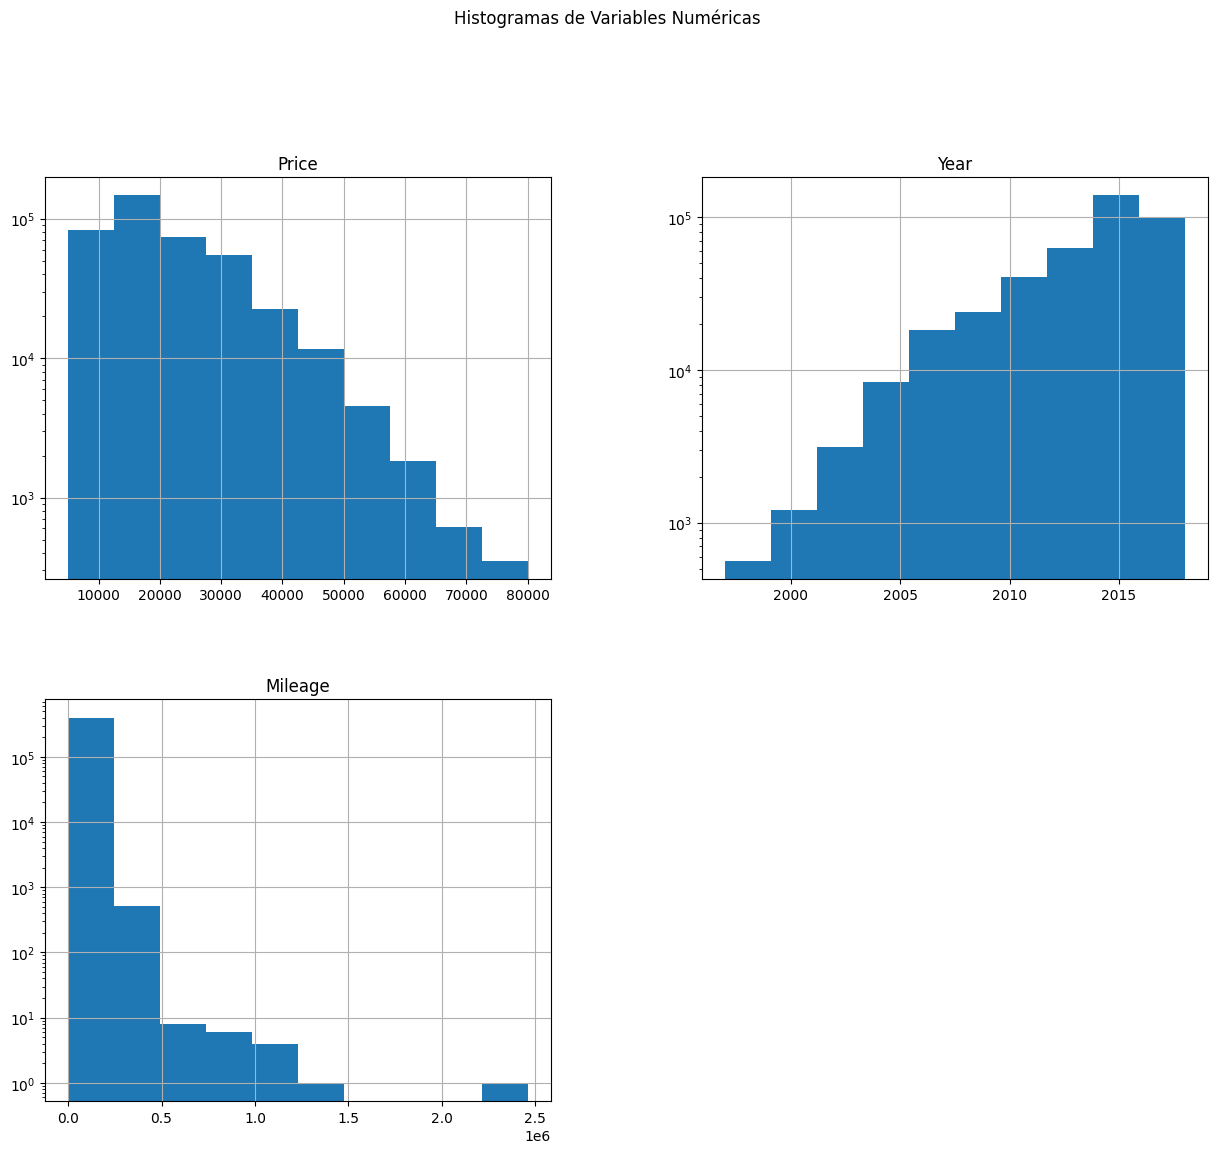

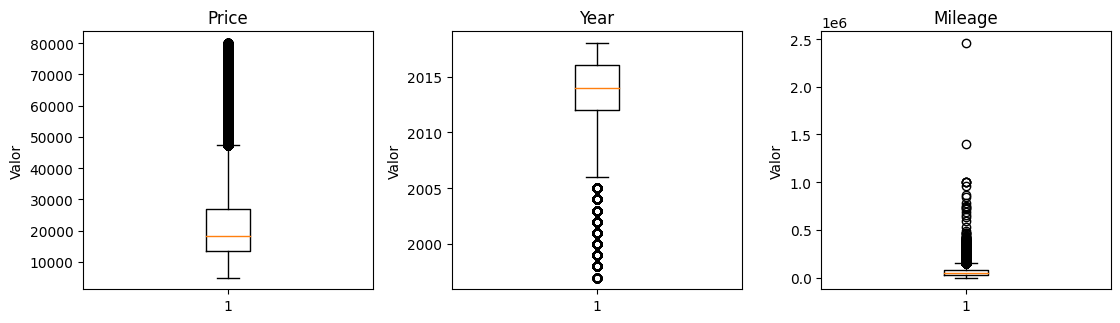

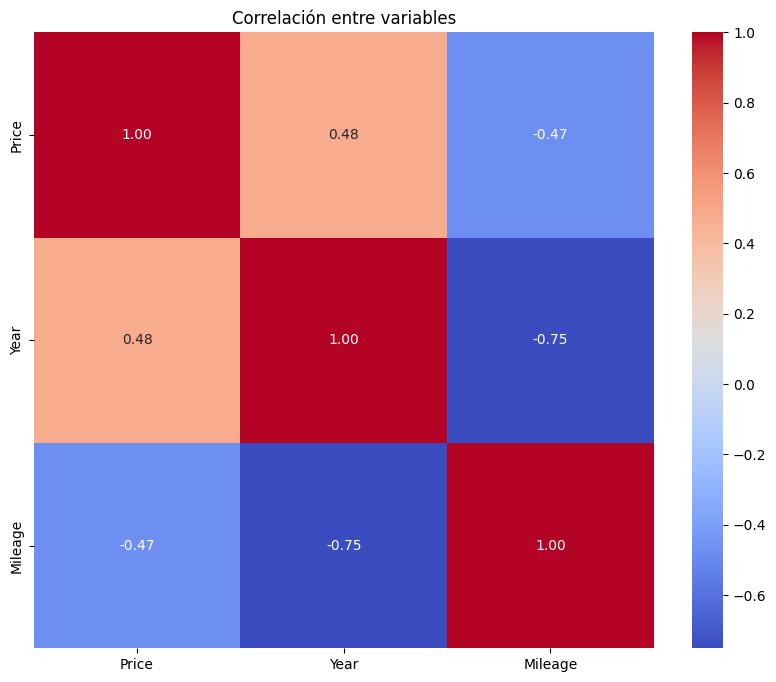

In [5]:
# Resumen estadístico de las variables numéricas
print("Resumen estadístico de las variables numéricas")
print(df_train2.describe())

#Distribucciones de las variables numericas
import matplotlib.pyplot as plt
import seaborn as sns

df_numeric = df_train2.select_dtypes(include=['int', 'float'])
# Histogramas de las variables numéricas
plt.figure(figsize=(15, 12))
df_numeric.hist(figsize=(15, 12), log=True)
plt.suptitle("Histogramas de Variables Numéricas", y=1.02)
plt.show()

#Analizando valores atipicos
plt.figure(figsize=(15, 12))
for i, col in enumerate(df_numeric.columns):
    plt.subplot(4, 4, i+1) 
    plt.boxplot(df_numeric[col])
    plt.title(col)
    plt.ylabel("Valor")
plt.tight_layout()
plt.show()

# Correlación general y mapa de calor
correlation_matrix = df_numeric.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlación entre variables')
plt.show()

Valor unicos de las variables categoricas
Columna: State
 TX    45914
 CA    36512
 FL    33713
 GA    18180
 NC    17928
 IL    16788
 VA    15893
 PA    13035
 NY    12446
 NJ    12130
 OH    11364
 WA    10898
 CO    10870
 AZ    10747
 TN     9273
 MA     8586
 MD     8243
 MO     8029
 IN     7850
 KY     6688
 AL     6282
 WI     5612
 MN     5415
 MI     5326
 OK     5096
 CT     4942
 OR     4907
 SC     4814
 UT     4795
 LA     3847
 KS     3704
 NV     3332
 AR     3125
 MS     3043
 NH     2744
 NE     2522
 IA     2325
 NM     2280
 ID     1736
 DE     1221
 HI     1180
 MT      997
 ME      965
 RI      833
 AK      813
 ND      681
 WV      666
 SD      621
 VT      579
 WY      335
 DC        6
Name: State, dtype: int64


Columna: Make
Ford             62837
Chevrolet        58354
Toyota           45903
Honda            33188
Jeep             24366
GMC              20834
Kia              16341
Dodge            16158
Hyundai          15054
Lexus            13663
BMW     

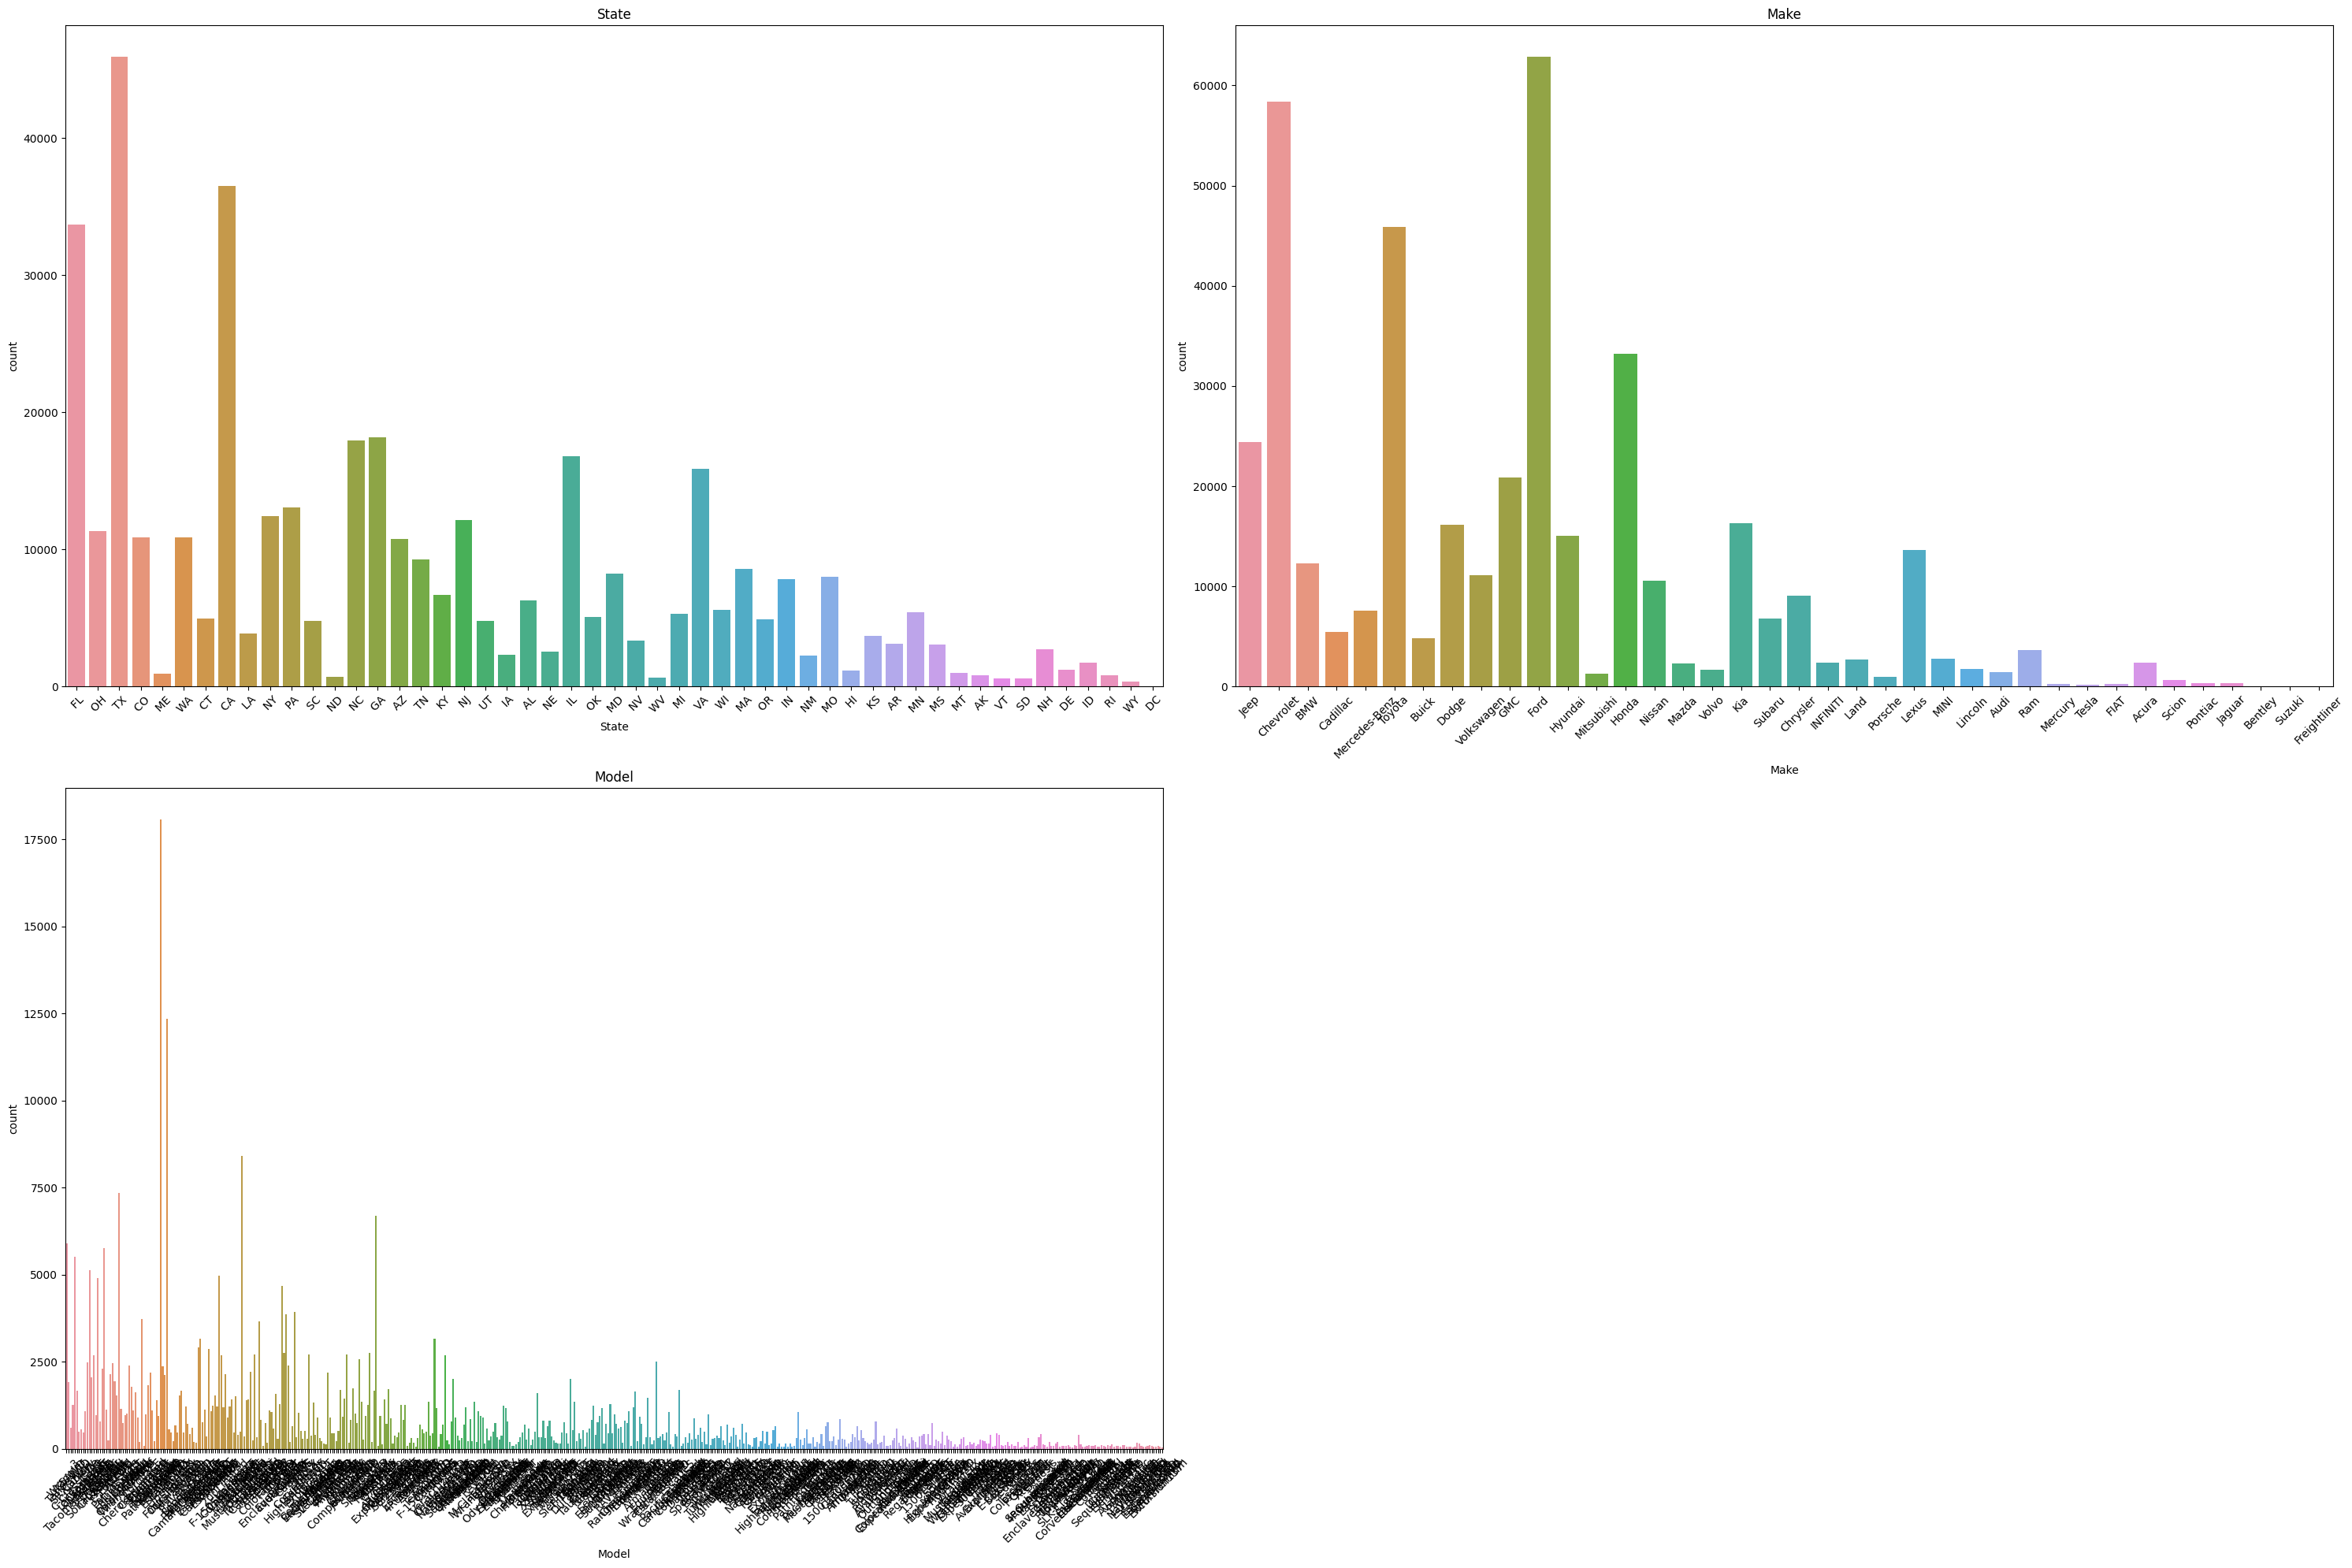

Analisis de correlacion con la variable objeivo price
Relación entre State y la variable objetivo:
State
 AK    21988.726937
 AL    22429.400191
 AR    23750.631360
 AZ    20039.249000
 CA    20526.674408
 CO    21158.158970
 CT    18802.669365
 DC    11872.000000
 DE    21022.352170
 FL    20069.581259
 GA    21073.261166
 HI    17288.082203
 IA    22190.412043
 ID    21879.111751
 IL    20614.453955
 IN    20099.591720
 KS    20964.339093
 KY    20914.152362
 LA    23477.059787
 MA    21391.870603
 MD    20372.163533
 ME    22471.632124
 MI    19750.847728
 MN    21323.823084
 MO    21312.057791
 MS    24357.383174
 MT    25385.744233
 NC    21310.861557
 ND    21483.114537
 NE    22813.591197
 NH    21189.571429
 NJ    20738.000907
 NM    23647.096930
 NV    20494.521309
 NY    21512.411538
 OH    19178.735832
 OK    22249.835557
 OR    21727.162421
 PA    21024.878634
 RI    22026.865546
 SC    21039.551516
 SD    25078.223833
 TN    21121.394910
 TX    23270.200919
 UT    22270.64

In [6]:
#Valor unicos de las variables categoricas
print('Valor unicos de las variables categoricas')
for col in df_train2.select_dtypes(include=['object']).columns:
    print(f"Columna: {col}")
    print(df_train2[col].value_counts())
    print("\n")

#distribuiccion de las variables categoricas
print('Distribuiccion de las variables categoricas')
plt.figure(figsize=(30, 20))
for i, col in enumerate(df_train2.select_dtypes(include=['object']).columns):
    plt.subplot(2, 2, i+1)
    sns.countplot(x=col, data=df_train2)
    plt.title(col)
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#Analisis de correlacion con la variable objeivo price
print('Analisis de correlacion con la variable objeivo price')
for col in df_train2.select_dtypes(include=['object']).columns:
    print(f"Relación entre {col} y la variable objetivo:")
    print(df_train2.groupby(col)['Price'].mean())
    print("\n")

BOXPLOT DE Price
count    399831.000000
mean      21143.998537
std       10751.954687
min        5001.000000
25%       13499.000000
50%       18449.000000
75%       26999.000000
max       79999.000000
Name: Price, dtype: float64


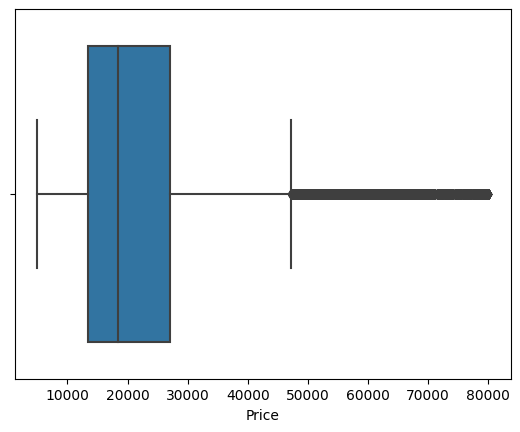

In [7]:
#Datos atipicos en vble Price
print('BOXPLOT DE Price')
sns.boxplot(x='Price', data=df_train2)

descripcion_variable_objetivo = df_train2['Price'].describe()
print(descripcion_variable_objetivo)

# PREPROCESAMIENTO
(10 puntos) Los datos de entrenamiento se dividen en datos de entrenamiento y validación. Si decidieron preprocesar los datos (estandarizar, normalizar, imputar valores, etc), estos son correctamente preprocesados al ajustar sobre los datos de entrenamiento (.fit_transform()) y al transformar los datos del set de validación (.transform()). (10 puntos)

In [3]:
#Identificando valores atipicos de Mileage y quitandolos 
df_train3 = df_train2[df_train2['Mileage'] <= 1500000]
print(df_train2.shape)
print(df_train3.shape)

# División de datos en características y variable objetivo
X = df_train3.drop('Price', axis=1)
y = df_train3['Price']

#limpieza de vbles categoricas
X['State'] = quitartildes(X['State'])
X['Model'] = quitartildes(X['Model'])
X['Make'] = quitartildes(X['Make'])

#Ingenieria de caracteristicas
current_year = datetime.now().year
X['Car_Age'] = current_year - X['Year']
X['Mileage_Year'] = X['Year'] / X['Mileage']
X['Brand_Model'] = X['Make'] + '_' + X['Model']
#Calculando mileage_range
q1 = X['Mileage'].quantile(0.25)
q2 = X['Mileage'].quantile(0.5)
q3 = X['Mileage'].quantile(0.75)

# Define los rangos
rango_bajo = X['Mileage'] <= q1
rango_medio = (X['Mileage'] > q1) & (X['Mileage'] <= q2)
rango_alto = (X['Mileage'] > q2) & (X['Mileage'] <= q3)
rango_muy_alto = X['Mileage'] > q3
X['mileage_range'] = ''
X.loc[rango_bajo, 'mileage_range'] = 'Bajo'
X.loc[rango_medio, 'mileage_range'] = 'Medio'
X.loc[rango_alto, 'mileage_range'] = 'Alto'
X.loc[rango_muy_alto, 'mileage_range'] = 'Muy Alto'
X = X.drop(["Mileage","Make"], axis=1)

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Definición de transformadores para características numéricas y categóricas
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

# ColumnTransformer para aplicar transformadores a diferentes tipos de características
preprocessor = ColumnTransformer(
    transformers=[
        #('remove_accents', RemoveAccentsTransformer(), ['State', 'Model', 'Make']),
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Pipeline que incluye el preprocesamiento y el modelo
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)])

# Aplicar el pipeline a los datos
X_preprocessed = pipeline.fit_transform(X)

# Division de los datos
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.33, random_state=42)

(399831, 6)
(399830, 6)


# CALIBRACIÓN DEL MODELO
(15 puntos)

Se calibran los parámetros que se consideren pertinentes del modelo de clasificación seleccionado. (5 puntos)
Se justifica el método seleccionado de calibración. (5 puntos)
Se analizan los valores calibrados de cada parámetro y se explica cómo afectan el modelo. (5 puntos)

In [ ]:
#Calibrando el modelo de xgboost
param_grid_xgboost = {
    'n_estimators': [300, 400, 500],
    'learning_rate': [0.1, 0.2,0.5],
    'max_depth': [7, 8, 9],
    'subsample': [0.9, 0.95, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'reg_lambda' : [1,1.5,2],
    'gamma': [0.3,0.4]}

modelo_xgboost = XGBRegressor(random_state=12345)#Poner semilla de 12345

# Realizar la búsqueda aleatoria de hiperparámetros
random_search = RandomizedSearchCV(estimator=modelo_xgboost, param_distributions=param_grid_xgboost, 
                                   n_iter=50, cv=5, scoring='neg_mean_squared_error', 
                                   random_state=42, n_jobs=-1)

# Ajustar la búsqueda aleatoria a los datos de entrenamiento
random_search.fit(X_train, y_train)

# Obtener los mejores hiperparámetros
best_params = random_search.best_params_
print("Mejores hiperparámetros:", best_params)
#Mejores hiperparámetros: {subsample= 0.95, reg_lambda= 1.5, n_estimators= 500, max_depth= 7, learning_rate= 0.1, gamma= 0.3, colsample_bytree=0.8}
# se usa ramdomized porque es mas liviano que gridsearch

# ENTRENAMIENTO DEL MODELO
(15 puntos)

Se entrena el modelo de clasificación escogido con los datos del set de entrenamiento preprocesados y los parámetros óptimos. (5 puntos)
Se presenta el desempeño del modelo en los datos de validación con al menos una métrica de desempeño. (5 puntos)
Se justifica la selección del modelo correctamente. (5 puntos)

In [ ]:
#XGBOOST con rango de mileage aplicando mejores hiperparametros
xgboost_model2 = XGBRegressor(random_state=12345,subsample= 0.95, reg_lambda= 1.5, n_estimators= 500, max_depth= 7, learning_rate= 0.1, gamma= 0.3, colsample_bytree=0.8)
xgboost_model2.fit(X_train, y_train)
y_pred_xgb = xgboost_model2.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred_xgb)
print(rmse)
#rmse: 3483.9723415061567

In [ ]:
#STACKING1 CON LINEAL CON RANGO EN MILEAGE
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Definir los estimadores base que serán utilizados en el ensamble
estimators = [
    ('xgb', XGBRegressor(random_state=12345,subsample= 0.95, reg_lambda= 1.5, n_estimators= 500, max_depth= 7, learning_rate= 0.1, gamma= 0.3, colsample_bytree=0.8)),                 
    ('rf', RandomForestRegressor())          
]
final_estimator = LinearRegression()
stacking_model2 = StackingRegressor(estimators=estimators, final_estimator=final_estimator)
stacking_model2.fit(X_train, y_train)
y_pred_stacking2 = stacking_model2.predict(X_test)
rmse_stacking = mean_squared_error(y_test, y_pred_stacking, squared=False)
print("RMSE en los datos de prueba para el ensamble Stacking:", rmse_stacking)
#RMSE en los datos de prueba para el ensamble Stacking: 3468.6428600200097
#Kaggle:3470

In [ ]:
#STACKING2 CON GB COMO ESTIMADOR FINAL
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Definir los estimadores base que serán utilizados en el ensamble
estimators = [
    ('xgb', XGBRegressor(random_state=12345, subsample=0.95, reg_lambda=1.5, n_estimators=500, max_depth=7, learning_rate=0.1, gamma=0.3, colsample_bytree=0.8)),                 
    ('rf', RandomForestRegressor())          
]
final_estimator = GradientBoostingRegressor()  # Cambio aquí: Usar GradientBoostingRegressor como estimador final
stacking_model4 = StackingRegressor(estimators=estimators, final_estimator=final_estimator)
stacking_model4.fit(X_train, y_train)
y_pred_stacking4 = stacking_model4.predict(X_test)
rmse_stacking4 = mean_squared_error(y_test, y_pred_stacking4, squared=False)
print("RMSE en los datos de prueba para el ensamble Stacking con Gradient Boosting:", rmse_stacking4)
#RMSE en los datos de prueba para el ensamble Stacking con Gradient Boosting: 3469.8081233800754
#Kaggle:3472

In [ ]:
#STACKING3: xgb,rf,lineal y GB
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Definir los estimadores base que serán utilizados en el ensamble
estimators = [
    ('xgb', XGBRegressor(random_state=12345,subsample= 0.95, reg_lambda= 1.5, n_estimators= 500, max_depth= 7, learning_rate= 0.1, gamma= 0.3, colsample_bytree=0.8)),                 
    ('rf', RandomForestRegressor()) ,
    ('GB', GradientBoostingRegressor(random_state=12345,learning_rate=0.4,max_depth= 10)) ,# PROBAR CON learning_rate=0.5,
    ('lineal',LinearRegression())         
]
final_estimator = LinearRegression()
stacking_model = StackingRegressor(estimators=estimators, final_estimator=final_estimator)
stacking_model.fit(X_train, y_train)
y_pred_stacking = stacking_model.predict(X_test)
rmse_stacking = mean_squared_error(y_test, y_pred_stacking, squared=False)
print("RMSE en los datos de prueba para el ensamble Stacking:", rmse_stacking)
#RMSE en los datos de prueba para el ensamble Stacking: 3463.1499482407007
#rmse en kaggle 3463.60379 el mejor

In [4]:
#STACKING4: MODELO FINAL#####################
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Definir los estimadores base y agregar ElasticNet Regression
estimators = [
    ('xgb', XGBRegressor(random_state=12345, subsample=0.95, reg_lambda=1.5, n_estimators=500, max_depth=7, learning_rate=0.1, gamma=0.3, colsample_bytree=0.8)),
    ('rf', RandomForestRegressor()),
    ('GB', GradientBoostingRegressor(random_state=12345, learning_rate=0.4, max_depth=10)),
    ('lineal', LinearRegression()),
    ('elasticnet', ElasticNet())
]

final_estimator = LinearRegression()
stacking_model5 = StackingRegressor(estimators=estimators, final_estimator=final_estimator)
stacking_model5.fit(X_train, y_train)
y_pred_stacking = stacking_model5.predict(X_test)
rmse_stacking = mean_squared_error(y_test, y_pred_stacking, squared=False)
print("RMSE en los datos de prueba para el ensamble Stacking con ElasticNet Regression:", rmse_stacking)
#RMSE: 3460
#KAGGLE: 3457

RMSE en los datos de prueba para el ensamble Stacking con ElasticNet Regression: 3504.904229550187


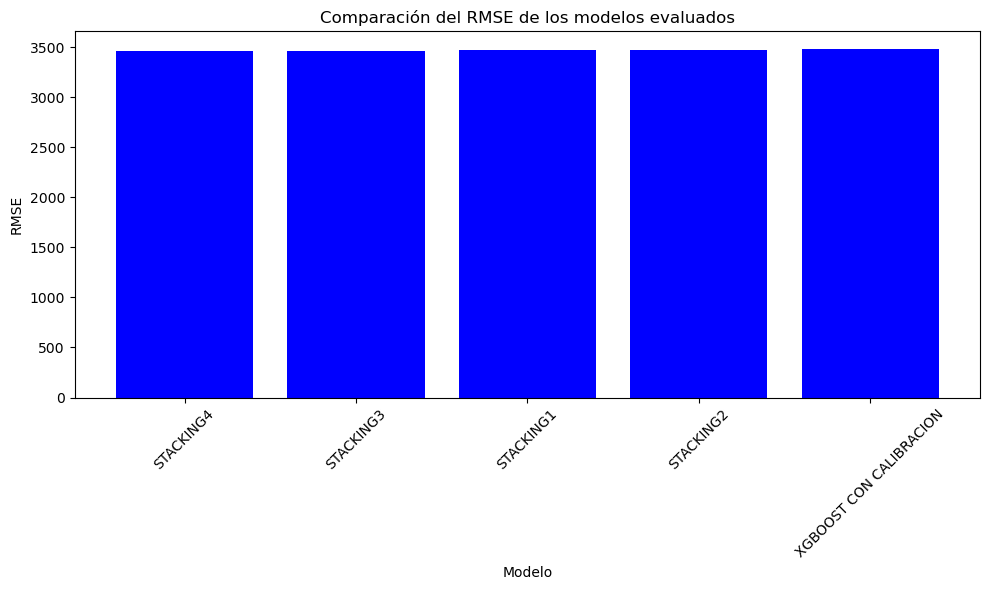

In [12]:
import matplotlib.pyplot as plt

# Comparando métricas de los modelos
rmse_values = [3483.97234,3468.6429,3469.8081,3463.14993,3460]
model_names = ['XGBOOST CON CALIBRACION','STACKING1','STACKING2','STACKING3','STACKING4']

# Ordenando métricas
sorted_models_rmse = [model_name for _, model_name in sorted(zip(rmse_values, model_names))]
sorted_rmse_values = sorted(rmse_values)

# Creando el histograma
plt.figure(figsize=(10, 6))
plt.bar(sorted_models_rmse, sorted_rmse_values, color='blue')
plt.title('Comparación del RMSE de los modelos evaluados')
plt.xlabel('Modelo')
plt.ylabel('RMSE')
plt.xticks(rotation=45)  
plt.tight_layout()  
plt.show()

In [ ]:
#data de competencia con rango de mileage
dataTesting['State'] = quitartildes(dataTesting['State'])
dataTesting['Model'] = quitartildes(dataTesting['Model'])
dataTesting['Make'] = quitartildes(dataTesting['Make'])
dataTesting['Car_Age'] = current_year - dataTesting['Year']
dataTesting['Mileage_Year'] = dataTesting['Year'] / dataTesting['Mileage']
dataTesting['Brand_Model'] = dataTesting['Make'] + '_' + dataTesting['Model']
rango_bajo = dataTesting['Mileage'] <= q1
rango_medio = (dataTesting['Mileage'] > q1) & (dataTesting['Mileage'] <= q2)
rango_alto = (dataTesting['Mileage'] > q2) & (dataTesting['Mileage'] <= q3)
rango_muy_alto = dataTesting['Mileage'] > q3
dataTesting['mileage_range'] = ''
dataTesting.loc[rango_bajo, 'mileage_range'] = 'Bajo'
dataTesting.loc[rango_medio, 'mileage_range'] = 'Medio'
dataTesting.loc[rango_alto, 'mileage_range'] = 'Alto'
dataTesting.loc[rango_muy_alto, 'mileage_range'] = 'Muy Alto'
dataTesting = dataTesting.drop(["Mileage","Make"], axis=1)

X_testcru = pipeline.transform(dataTesting)
y_predmodelo1 = stacking_model5.predict(X_testcru)
print(y_predmodelo1[:5]) 
df = pd.DataFrame(y_predmodelo1) 
df = df.rename(columns={0: 'Price'}) 
df.to_csv(r"stacking14.csv", index_label='ID') 

In [6]:
import sklearn
import joblib
print(sklearn.__version__)
joblib.dump(stacking_model5, 'modelo.pkl', protocol=4)

1.4.2


['modelo.pkl']

# DISPONIBILIZACIÓN DEL MODELO
(30 puntos)

Se disponibiliza el modelo en una API alojada en un servicio en la nube. (20 puntos)
Se hacen las predicciones sobre el valor del automóvil en al menos dos observaciones del set de validación. (10 puntos)

# CONCLUSIONES
(10 puntos)

Se presentan conclusiones claras y concisas sobre el desarrollo y los resultados del proyecto. (10 puntos)